In [283]:
from sklearn.model_selection import train_test_split
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error

In [284]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing0 = load_housing_data()

In [285]:
housing0["income_cat"] = pd.cut(housing0["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

In [286]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits = []
for train_index, test_index in splitter.split(housing0, housing0["income_cat"]):
    strat_train_set_n = housing0.iloc[train_index]
    strat_test_set_n = housing0.iloc[test_index]
    strat_splits.append([strat_train_set_n, strat_test_set_n])

In [287]:
strat_train_set, strat_test_set = train_test_split(
    housing0, test_size=0.2, stratify=housing0["income_cat"], random_state=42)

In [288]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing0, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall %": income_cat_proportions(housing0),
    "Stratified %": income_cat_proportions(strat_test_set),
    "Random %": income_cat_proportions(test_set),
}).sort_index()
compare_props.index.name = "Income Category"
compare_props["Strat. Error %"] = (compare_props["Stratified %"] /
                                   compare_props["Overall %"] - 1)
compare_props["Rand. Error %"] = (compare_props["Random %"] /
                                  compare_props["Overall %"] - 1)
(compare_props * 100).round(2)

,Overall %,Stratified %,Random %,Strat. Error %,Rand. Error %
Income Category,,,,,
1,3.98,4.00,4.24,0.36,6.45
2,31.88,31.88,30.74,-0.02,-3.59
3,35.06,35.05,34.52,-0.01,-1.53
4,17.63,17.64,18.41,0.03,4.42
5,11.44,11.43,12.09,-0.08,5.63


In [289]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)
housing1 = strat_train_set.copy()

In [290]:
housing1["rooms_per_house"] = housing1["total_rooms"] / housing1["households"]
housing1["bedrooms_ratio"] = housing1["total_bedrooms"] / housing1["total_rooms"]
housing1["people_per_house"] = housing1["population"] / housing1["households"]

In [291]:
corr_matrix = housing1.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
rooms_per_house       0.143663
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
people_per_house     -0.038224
longitude            -0.050859
latitude             -0.139584
bedrooms_ratio       -0.256397
Name: median_house_value, dtype: float64

Reverting to old data where no rooms_per_house, bedrooms_ratio, people_per_house were there.

In [292]:
housing2 = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [293]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
housing_num = housing2.select_dtypes(include=[np.number])
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [294]:
X = imputer.transform(housing_num)
imputer.feature_names_in_

array(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype=object)

In [295]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)

In [296]:
housing_tr

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292
...,...,...,...,...,...,...,...,...
14207,-118.40,33.86,41.0,2237.0,597.0,938.0,523.0,4.7105
13105,-119.31,36.32,23.0,2945.0,592.0,1419.0,532.0,2.5733
19301,-117.06,32.59,13.0,3920.0,775.0,2814.0,760.0,4.0616
19121,-118.40,34.06,37.0,3781.0,873.0,1725.0,838.0,4.1455


In [297]:
from sklearn.ensemble import IsolationForest

isolation_forest = IsolationForest(random_state=42)
outlier_pred = isolation_forest.fit_predict(X)
(outlier_pred == -1).sum()

2064

This unsupervised algorithm IsolationForest finds out the outlier. There are 2064 outliers out of 16512 total values

In [298]:
housing3 = housing2.iloc[outlier_pred == 1]
housing_labels = housing_labels.iloc[outlier_pred == 1]

In [299]:
housing = housing3
housing["median_house_value"] = housing_labels

C:\Users\huzai\AppData\Local\Temp\ipykernel_13804\28357427.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  housing["median_house_value"] = housing_labels


Removed outliers.

In [300]:
housing["bedroom_room_ratio"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["people_per_house"] = housing["population"]/housing["households"]
housing["rooms_per_house"] = housing["total_rooms"]/housing["households"]
housing["people_per_room"] = housing["population"]/housing["total_rooms"]

C:\Users\huzai\AppData\Local\Temp\ipykernel_13804\4095131851.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  housing["bedroom_room_ratio"] = housing["total_bedrooms"]/housing["total_rooms"]
C:\Users\huzai\AppData\Local\Temp\ipykernel_13804\4095131851.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  housing["people_per_house"] = housing["population"]/housing["households"]
C:\Users\huzai\AppData\Local\Temp\ipykernel_13804\4095131851.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy o

Text(0.5, 1.0, 'Histogram of Housing Median Age with Stacked Colors Representing House Prices')

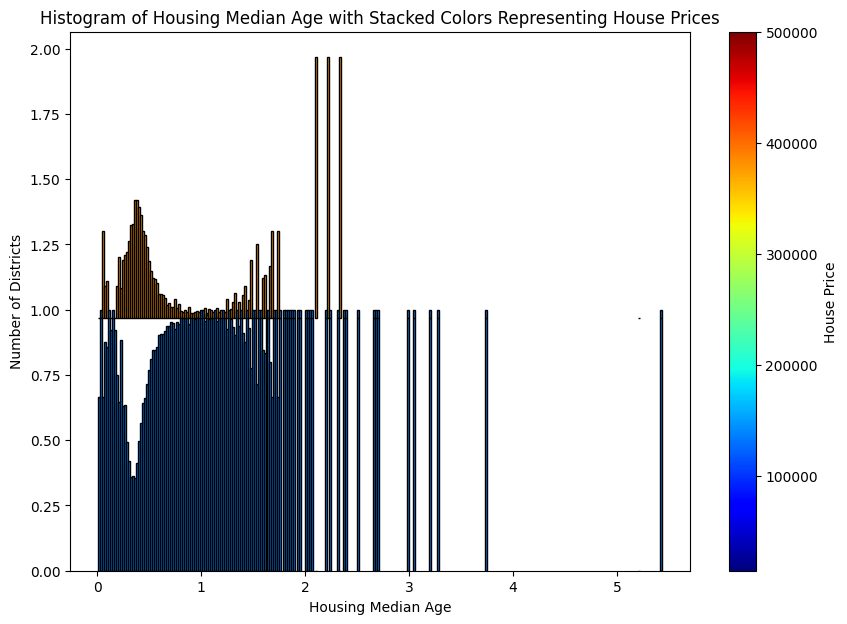

In [301]:
import matplotlib.colors as mcolors
import numpy as np

x = "people_per_room"

min_x = housing[x].min()
max_x = housing[x].max()
min_price = housing["median_house_value"].min()
max_price = housing["median_house_value"].max()

bottom = [0]

x_bins = np.linspace(min_x, max_x , 500) # (1, 52, 52) every age point
price_bins = [min_price, 260000, max_price]

cmap = plt.get_cmap('jet')
norm = mcolors.Normalize(vmin=min_price, vmax=max_price)

fig, ax  = plt.subplots(figsize=(10, 7))

for i in range(len(x_bins)-1):
    in_bin = ((housing[x] >= x_bins[i]) & (housing[x] < x_bins[i+1]))
    tot_in_x_bin = np.sum(in_bin)

    if tot_in_x_bin == 0:
        continue

    for j in range(len(price_bins)-1):
        in_price_bin = (in_bin & ((housing["median_house_value"] >= price_bins[j]) & (housing["median_house_value"] < price_bins
                                 [j+1])))
        tot_in_price_bin = np.sum(in_price_bin)
        color = cmap(norm((price_bins[j]+price_bins[j+1])/2))
        ax.bar(x_bins[i], tot_in_price_bin/tot_in_x_bin, width=x_bins[i+1]-x_bins[i], bottom=bottom[j], color=color, edgecolor='black')
        if i == 0 and j == 2:
            bottom.append(bottom[j]+tot_in_price_bin/tot_in_x_bin + 0.7)
        else:
            bottom.append(bottom[j]+tot_in_price_bin/tot_in_x_bin + 0.3)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax) 
cbar.set_label('House Price')

# Set labels and title
ax.set_xlabel('Housing Median Age')
ax.set_ylabel('Number of Districts')
ax.set_title('Histogram of Housing Median Age with Stacked Colors Representing House Prices')

In [302]:
housing3 = housing[~((housing["population"] < 300) | (housing["people_per_house"] > 6) | (housing["rooms_per_house"] > 10))]

First using above 2d colour histogram checked every numerical attribute relationship to median price and removed 171 extreme outliers. while checking it. 

In [303]:
# Dropping columns
housing_labels = housing3["median_house_value"]
housing3.drop(columns=["bedroom_room_ratio", "people_per_house", "rooms_per_house", "median_house_value"], inplace=True)



C:\Users\huzai\AppData\Local\Temp\ipykernel_13804\3399244203.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  housing3.drop(columns=["bedroom_room_ratio", "people_per_house", "rooms_per_house", "median_house_value"], inplace=True)


In [304]:
housing3.size

140360

In [305]:
housing3.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,people_per_room
count,14036.000000,14036.000000,14036.000000,14036.000000,13900.000000,14036.000000,14036.000000,14036.000000,14036.000000
mean,-119.517682,35.536513,29.545882,2285.965304,470.784604,1273.549516,443.997649,3.789655,0.592295
std,1.929455,2.047795,12.009216,1100.664502,226.174340,627.157486,208.472640,1.675709,0.231213
min,-123.810000,32.550000,1.000000,151.000000,60.000000,300.000000,65.000000,0.549500,0.167941
25%,-121.640000,33.930000,20.000000,1477.750000,303.000000,815.750000,290.000000,2.574300,0.443418
50%,-118.450000,34.220000,30.000000,2073.000000,424.000000,1150.000000,403.000000,3.527800,0.523002
75%,-118.020000,37.660000,37.000000,2893.000000,593.000000,1600.000000,559.000000,4.682850,0.666667
max,-114.570000,41.740000,52.000000,7508.000000,1494.000000,5116.000000,1492.000000,15.000100,3.205714


In [306]:
housing3["median_housing_value"] = housing_labels
housing3

C:\Users\huzai\AppData\Local\Temp\ipykernel_13804\2738197173.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  housing3["median_housing_value"] = housing_labels


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,people_per_room,median_housing_value
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876,<1H OCEAN,0.338931,483800.0
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330,INLAND,0.518929,101700.0
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618,INLAND,0.442022,96100.0
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292,NEAR OCEAN,0.437929,361800.0
1286,-121.31,37.96,52.0,1829.0,301.0,694.0,319.0,3.3466,INLAND,0.379442,92600.0
...,...,...,...,...,...,...,...,...,...,...,...
14207,-118.40,33.86,41.0,2237.0,597.0,938.0,523.0,4.7105,<1H OCEAN,0.419312,500001.0
13105,-119.31,36.32,23.0,2945.0,592.0,1419.0,532.0,2.5733,INLAND,0.481834,88800.0
19301,-117.06,32.59,13.0,3920.0,775.0,2814.0,760.0,4.0616,NEAR OCEAN,0.717857,148800.0
19121,-118.40,34.06,37.0,3781.0,873.0,1725.0,838.0,4.1455,<1H OCEAN,0.456229,500001.0


In [307]:
housing3.drop("median_housing_value", axis=1, inplace=True)

C:\Users\huzai\AppData\Local\Temp\ipykernel_13804\2397232256.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  housing3.drop("median_housing_value", axis=1, inplace=True)


In [308]:
from sklearn.preprocessing import OneHotEncoder

housing_cat = housing3[["ocean_proximity"]]
cat_encoder = OneHotEncoder(sparse_output=False)
cat_encoder.handle_unknown = "ignore"
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [309]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [310]:
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, n_init=10,
                              random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self  # always return self!

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    
    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

In [311]:
cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))

In [312]:
from sklearn import set_config

set_config(display='diagram')

In [313]:
def monkey_patch_get_signature_names_out():
    """Monkey patch some classes which did not handle get_feature_names_out()
       correctly in Scikit-Learn 1.0.*."""
    from inspect import Signature, signature, Parameter
    import pandas as pd
    from sklearn.impute import SimpleImputer
    from sklearn.pipeline import make_pipeline, Pipeline
    from sklearn.preprocessing import FunctionTransformer, StandardScaler

    default_get_feature_names_out = StandardScaler.get_feature_names_out

    if not hasattr(SimpleImputer, "get_feature_names_out"):
      print("Monkey-patching SimpleImputer.get_feature_names_out()")
      SimpleImputer.get_feature_names_out = default_get_feature_names_out

    if not hasattr(FunctionTransformer, "get_feature_names_out"):
        print("Monkey-patching FunctionTransformer.get_feature_names_out()")
        orig_init = FunctionTransformer.__init__
        orig_sig = signature(orig_init)

        def __init__(*args, feature_names_out=None, **kwargs):
            orig_sig.bind(*args, **kwargs)
            orig_init(*args, **kwargs)
            args[0].feature_names_out = feature_names_out

        __init__.__signature__ = Signature(
            list(signature(orig_init).parameters.values()) + [
                Parameter("feature_names_out", Parameter.KEYWORD_ONLY)])

        def get_feature_names_out(self, names=None):
            if callable(self.feature_names_out):
                return self.feature_names_out(self, names)
            assert self.feature_names_out == "one-to-one"
            return default_get_feature_names_out(self, names)

        FunctionTransformer.__init__ = __init__
        FunctionTransformer.get_feature_names_out = get_feature_names_out

monkey_patch_get_signature_names_out()

In [314]:
urban_centers = np.array([
    [34.0522, -118.2437],  # Los Angeles
    [37.7749, -122.4194],  # San Francisco
    [37.3382, -121.8863],  # San Jose
    [32.7157, -117.1611],  # San Diego
]
)

In [315]:
def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]  # feature names out

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler())

log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler())
cluster_simil = ClusterSimilarity(n_clusters=60, gamma=1., random_state=42)
default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                                     StandardScaler())


preprocessing = ColumnTransformer(
    transformers=[
        ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
        ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
        ("people_per_house", ratio_pipeline(), ["population", "households"]),
        ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population",
                                  "households", "median_income"]),
        ("geo", cluster_simil, ["latitude", "longitude"]),
        ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
    ],
    remainder=default_num_pipeline
)


In [316]:
housing_prepared = preprocessing.fit_transform(housing3)
housing_prepared.shape

(14036, 75)

In [317]:
preprocessing.get_feature_names_out()

array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'geo__Cluster 0 similarity',
       'geo__Cluster 1 similarity', 'geo__Cluster 2 similarity',
       'geo__Cluster 3 similarity', 'geo__Cluster 4 similarity',
       'geo__Cluster 5 similarity', 'geo__Cluster 6 similarity',
       'geo__Cluster 7 similarity', 'geo__Cluster 8 similarity',
       'geo__Cluster 9 similarity', 'geo__Cluster 10 similarity',
       'geo__Cluster 11 similarity', 'geo__Cluster 12 similarity',
       'geo__Cluster 13 similarity', 'geo__Cluster 14 similarity',
       'geo__Cluster 15 similarity', 'geo__Cluster 16 similarity',
       'geo__Cluster 17 similarity', 'geo__Cluster 18 similarity',
       'geo__Cluster 19 similarity', 'geo__Cluster 20 similarity',
       'geo__Cluster 21 similarity', 'geo__Cluster 22 similarity',
       'geo__Cluster 23 similarity', 'ge

In [318]:
housing_prepared = pd.DataFrame(housing_prepared, index=housing3.index, columns=preprocessing.get_feature_names_out())
housing_prepared.head()

,bedrooms__ratio,rooms_per_house__ratio,people_per_house__ratio,log__total_bedrooms,log__total_rooms,log__population,log__households,log__median_income,geo__Cluster 0 similarity,geo__Cluster 1 similarity,...,geo__Cluster 57 similarity,geo__Cluster 58 similarity,geo__Cluster 59 similarity,cat__ocean_proximity_<1H OCEAN,cat__ocean_proximity_INLAND,cat__ocean_proximity_ISLAND,cat__ocean_proximity_NEAR BAY,cat__ocean_proximity_NEAR OCEAN,remainder__housing_median_age,remainder__people_per_room
14973,-0.588777,0.236852,-1.476235,-0.357914,-0.067404,-1.087127,-0.230263,1.288698,8.864246e-01,3.802188e-10,...,4.943490e-12,1.124220e-14,2.468099e-16,1.0,0.0,0.0,0.0,0.0,0.870539,-1.095840
3785,-0.228219,0.089615,-0.224725,-1.374928,-1.259021,-1.434231,-1.418710,-0.790716,8.279597e-16,4.430651e-01,...,8.050308e-01,2.349777e-01,4.640002e-01,0.0,1.0,0.0,0.0,0.0,0.287633,-0.317319
14689,-0.165587,0.103803,-0.783429,1.464805,1.439490,0.995937,1.415072,-0.956148,3.163064e-01,2.323914e-15,...,7.572846e-18,4.340394e-20,2.102512e-22,0.0,1.0,0.0,0.0,0.0,-1.044725,-0.649955
20507,1.145074,-1.310932,-1.800776,2.197932,1.529443,1.068860,2.272252,0.052600,9.915388e-01,5.598018e-12,...,5.137232e-14,6.732926e-17,1.101186e-18,0.0,0.0,0.0,0.0,1.0,0.537450,-0.667656
1286,-0.866675,0.436391,-1.046553,-0.694952,-0.210862,-1.002937,-0.467192,-0.067853,2.695568e-12,9.647206e-01,...,7.927692e-01,2.364140e-01,2.075339e-01,0.0,1.0,0.0,0.0,0.0,1.869807,-0.920623


In [319]:
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

xgb_reg = Pipeline([("preprocessing", preprocessing), 
                    ("xgb", XGBRegressor(random_state=42))])

xgb_rmses = -cross_val_score(xgb_reg, housing3, housing_labels,
                                scoring="neg_root_mean_squared_error", cv=3)

In [320]:
pd.Series(xgb_rmses).describe()

count        3.000000
mean     41971.810159
std       1163.326625
min      40628.560521
25%      41631.276940
50%      42633.993360
75%      42643.434978
max      42652.876596
dtype: float64

In [321]:
xgb_reg.fit(housing3, housing_labels)
housing_predictions = xgb_reg.predict(housing3)
forest_rmse = root_mean_squared_error(housing_labels, housing_predictions,)
forest_rmse

21970.982264171744

In [322]:
from sklearn.model_selection import RandomizedSearchCV

param_distribs =  {
    'preprocessing__geo__n_clusters': [55, 60, 65],
    'xgb__n_estimators': [500, 800, 1000, 1500, 2000, 2500],     
    'xgb__learning_rate': [0.02, 0.01, 0.03, 0.05, 0.06, 0.08],       
    'xgb__max_depth': [6, 8, 10, 15, 16, 18, 20],          
    'xgb__min_child_weight': [10, 15, 18],        
    'xgb__subsample': [0.65, 0.7, 0.75],        
    'xgb__colsample_bytree': [0.2, 0.3], 
    'xgb__gamma': [0, 0.1, 0.15, 5],     
    'xgb__reg_alpha': [0, 0.5, 1, 2, 0.2], 
    'xgb__reg_lambda': [0.01, 0.1, 1, 5, 10]
}
 


rnd_search = RandomizedSearchCV(
    xgb_reg, param_distributions=param_distribs, n_iter=10, cv=3,
    scoring='neg_root_mean_squared_error', random_state=42)

rnd_search.fit(housing3, housing_labels)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_...
                                        'xgb__gamma': [0, 0.1, 0.15, 5],
                                        'xgb__learning_rate': [0.02, 0.01, 0.03,
                                                               0.05, 0.06,
                                                               0.08],
                                        'xgb__max_depth': [6, 8, 10, 15, 16, 18,
                                                           20],
                                        'xgb__min_child_weight': [10, 15, 18],
                                        'xgb__n_estimators': [500, 800, 1000,
                                                              1500, 2000,
                                                              2500],
                                        'xgb__reg_alpha': [0, 0.5, 1, 2, 0.2],
                                        'xgb__reg_lambda': [0.01, 0.1, 1, 5,
                                                            10],
                                        'xgb__subsample': [0.65, 0.7, 0.75]},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [323]:
cv_res = pd.DataFrame(rnd_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgb__subsample,param_xgb__reg_lambda,param_xgb__reg_alpha,param_xgb__n_estimators,param_xgb__min_child_weight,param_xgb__max_depth,...,param_xgb__gamma,param_xgb__colsample_bytree,param_preprocessing__geo__n_clusters,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
6,8.920567,0.384841,0.058347,0.006978,0.75,0.01,0.2,500,15,18,...,5.00,0.2,65,"{'xgb__subsample': 0.75, 'xgb__reg_lambda': 0....",-36674.089527,-38926.629090,-38045.916114,-37882.211577,926.852380,1
0,10.426653,0.322723,0.059709,0.007019,0.75,1.00,0.0,500,15,20,...,0.15,0.2,55,"{'xgb__subsample': 0.75, 'xgb__reg_lambda': 1,...",-36805.752010,-38989.997978,-38031.498405,-37942.416131,893.936743,2
9,7.136942,0.106893,0.060805,0.004114,0.70,0.10,2.0,1500,15,8,...,0.00,0.3,65,"{'xgb__subsample': 0.7, 'xgb__reg_lambda': 0.1...",-36878.524449,-38818.002288,-38332.248893,-38009.591877,824.004140,3
2,12.525896,0.316087,0.065242,0.002130,0.70,1.00,0.0,800,18,20,...,0.15,0.2,55,"{'xgb__subsample': 0.7, 'xgb__reg_lambda': 1, ...",-37001.302387,-39044.913382,-38244.640577,-38096.952115,840.811269,4
7,8.899075,0.136715,0.053835,0.003415,0.65,10.00,0.0,800,18,15,...,0.15,0.2,55,"{'xgb__subsample': 0.65, 'xgb__reg_lambda': 10...",-37050.571062,-39141.597007,-38183.759691,-38125.309253,854.657716,5


In [324]:
cv_res.iloc[0]

mean_fit_time                                                                    8.920567
std_fit_time                                                                     0.384841
mean_score_time                                                                  0.058347
std_score_time                                                                   0.006978
param_xgb__subsample                                                                 0.75
param_xgb__reg_lambda                                                                0.01
param_xgb__reg_alpha                                                                  0.2
param_xgb__n_estimators                                                               500
param_xgb__min_child_weight                                                            15
param_xgb__max_depth                                                                   18
param_xgb__learning_rate                                                             0.03
param_xgb_

In [325]:
final_model = rnd_search.best_estimator_
feature_import = final_model["xgb"].feature_importances_
sorted(zip(feature_import, final_model["preprocessing"].get_feature_names_out()), reverse=True)

[(0.44717497, 'cat__ocean_proximity_INLAND'),
 (0.023399552, 'log__median_income'),
 (0.018957566, 'geo__Cluster 38 similarity'),
 (0.015105585, 'geo__Cluster 42 similarity'),
 (0.015049082, 'geo__Cluster 23 similarity'),
 (0.014305729, 'geo__Cluster 26 similarity'),
 (0.013427, 'geo__Cluster 32 similarity'),
 (0.012888367, 'geo__Cluster 39 similarity'),
 (0.012295414, 'geo__Cluster 45 similarity'),
 (0.011734469, 'geo__Cluster 57 similarity'),
 (0.011595204, 'geo__Cluster 30 similarity'),
 (0.011590315, 'geo__Cluster 36 similarity'),
 (0.011331049, 'geo__Cluster 11 similarity'),
 (0.011221422, 'geo__Cluster 63 similarity'),
 (0.010735504, 'geo__Cluster 47 similarity'),
 (0.010711037, 'geo__Cluster 27 similarity'),
 (0.01051, 'geo__Cluster 43 similarity'),
 (0.009934927, 'geo__Cluster 46 similarity'),
 (0.009880467, 'bedrooms__ratio'),
 (0.009481041, 'geo__Cluster 51 similarity'),
 (0.009470361, 'geo__Cluster 14 similarity'),
 (0.008020051, 'geo__Cluster 24 similarity'),
 (0.007781811,

In [ ]:
import optuna
from optuna.samplers import TPESampler
from sklearn.model_selection import cross_val_score

# Define objective function using the existing pipeline
def objective(trial):
    # Suggest hyperparameters for XGBRegressor
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 400, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 25),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'subsample': trial.suggest_float('subsample', 0.6, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0, 1),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
    }

    # Access the existing pipeline and modify the XGBoost model's hyperparameters
    xgb_reg.named_steps['xgb'].set_params(**param)


    scores = -cross_val_score(
        xgb_reg, housing3, housing_labels, cv=3, 
        scoring='neg_root_mean_squared_error'
    )

    return scores.mean()

# Create Optuna study with TPE Sampler and Median Pruner
sampler = TPESampler()
study = optuna.create_study(direction="minimize", sampler=sampler, pruner=optuna.pruners.MedianPruner())

# Optimize the study with 100 trials
study.optimize(objective, n_trials=100)

# Print the best hyperparameters found by Optuna
print(f"Best parameters: {study.best_params}")

C:\Users\huzai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-10-29 18:00:29,128] A new study created in memory with name: no-name-d420c501-bf42-4a4f-af19-ebbb6030dd8d
C:\Users\huzai\AppData\Local\Temp\ipykernel_444\1754878768.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
[I 2024-10-29 18:10:49,766] Trial 0 finished with value: 38573.75126078643 and parameters: {'n_estimators': 569, 'max_depth': 14, 'learning_rate': 0.014550910771264894, 'subsample': 0.93690646589651

In [ ]:
results = study.trials_dataframe().sort_values(by="value")
results.head(n=10)


In [ ]:
param = dict(results.iloc[0])
param

In [ ]:
keys_to_drop = ["number", "number", 'datetime_start', 'datetime_complete', 'duration', 'state', 'value']
for key in keys_to_drop:
    param.pop(key, None)
param

In [326]:
param = {'colsample_bytree': 0.23156174575739172,
 'learning_rate': 0.03355303228675172,
 'max_depth': 10,
 'min_child_weight': 2,
 'n_estimators': 465,
 'reg_alpha': 0.5479953975561015,
 'reg_lambda': 0.45507726952370925,
 'subsample': 0.9744976572285455}

In [327]:
xgb_reg1 = Pipeline([("preprocessing1", preprocessing), 
                    ("xgb1", XGBRegressor(random_state=42))])
xgb_reg1.named_steps["xgb1"].set_params(**param)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.23156174575739172, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.03355303228675172, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=465, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [328]:
housing3["median_housing_price"] = housing_labels

C:\Users\huzai\AppData\Local\Temp\ipykernel_13804\555233217.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  housing3["median_housing_price"] = housing_labels


In [329]:
housing3

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,people_per_room,median_housing_price
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876,<1H OCEAN,0.338931,483800.0
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330,INLAND,0.518929,101700.0
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618,INLAND,0.442022,96100.0
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292,NEAR OCEAN,0.437929,361800.0
1286,-121.31,37.96,52.0,1829.0,301.0,694.0,319.0,3.3466,INLAND,0.379442,92600.0
...,...,...,...,...,...,...,...,...,...,...,...
14207,-118.40,33.86,41.0,2237.0,597.0,938.0,523.0,4.7105,<1H OCEAN,0.419312,500001.0
13105,-119.31,36.32,23.0,2945.0,592.0,1419.0,532.0,2.5733,INLAND,0.481834,88800.0
19301,-117.06,32.59,13.0,3920.0,775.0,2814.0,760.0,4.0616,NEAR OCEAN,0.717857,148800.0
19121,-118.40,34.06,37.0,3781.0,873.0,1725.0,838.0,4.1455,<1H OCEAN,0.456229,500001.0


In [330]:
strat_train_set, strat_test_set = train_test_split(
 housing3, test_size=0.20, random_state=42)
train_labels = strat_train_set["median_housing_price"]
train_housing = strat_train_set.drop("median_housing_price", axis=1)
test_labels = strat_test_set["median_housing_price"]
test_housing = strat_test_set.drop("median_housing_price", axis=1)

In [331]:
housing3.drop("median_housing_price", axis=1, inplace=True)

C:\Users\huzai\AppData\Local\Temp\ipykernel_13804\1037966312.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  housing3.drop("median_housing_price", axis=1, inplace=True)


In [332]:
xgb_reg1.fit(train_housing, train_labels)
housing_predictions = xgb_reg1.predict(test_housing)
forest_rmse = root_mean_squared_error(test_labels, housing_predictions,)
forest_rmse

39124.90591958527

In [333]:
test_housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,people_per_room
13383,-118.40,34.03,36.0,1831.0,296.0,871.0,269.0,8.1484,<1H OCEAN,0.475696
3780,-117.31,34.17,25.0,2795.0,596.0,1650.0,569.0,3.0078,INLAND,0.590340
17909,-119.12,34.23,35.0,2028.0,554.0,2252.0,521.0,2.4643,NEAR OCEAN,1.110454
12975,-122.22,38.08,37.0,4590.0,857.0,2920.0,832.0,3.4360,NEAR BAY,0.636166
15661,-122.01,37.55,26.0,2068.0,532.0,1434.0,495.0,3.3008,NEAR BAY,0.693424
...,...,...,...,...,...,...,...,...,...,...
3240,-119.17,34.21,33.0,1039.0,256.0,1432.0,272.0,3.1103,NEAR OCEAN,1.378248
4325,-117.93,33.87,52.0,950.0,229.0,429.0,185.0,2.3150,<1H OCEAN,0.451579
11567,-122.01,36.98,47.0,1250.0,249.0,607.0,234.0,4.0417,NEAR OCEAN,0.485600
1855,-117.08,32.64,11.0,1651.0,533.0,947.0,515.0,1.6806,NEAR OCEAN,0.573592


In [334]:
test_labels

13383    500001.0
3780      87100.0
17909    182000.0
12975     94800.0
15661    224200.0
           ...   
3240     143500.0
4325     182100.0
11567    265300.0
1855     141700.0
12333     78300.0
Name: median_housing_price, Length: 2808, dtype: float64

In [335]:
x = xgb_reg1.named_steps["preprocessing1"]
shap_data = x.fit_transform(test_housing)
shap_data = pd.DataFrame(shap_data, columns=x.get_feature_names_out(), index=test_housing.index)

In [336]:
shap_data

,bedrooms__ratio,rooms_per_house__ratio,people_per_house__ratio,log__total_bedrooms,log__total_rooms,log__population,log__households,log__median_income,geo__Cluster 0 similarity,geo__Cluster 1 similarity,...,geo__Cluster 57 similarity,geo__Cluster 58 similarity,geo__Cluster 59 similarity,cat__ocean_proximity_<1H OCEAN,cat__ocean_proximity_INLAND,cat__ocean_proximity_ISLAND,cat__ocean_proximity_NEAR BAY,cat__ocean_proximity_NEAR OCEAN,remainder__housing_median_age,remainder__people_per_room
13383,-0.940185,1.415824,0.468330,-0.745913,-0.208307,-0.517573,-0.838578,1.995892,9.179151e-01,3.102318e-13,...,2.015477e-12,6.235426e-01,4.396724e-19,1.0,0.0,0.0,0.0,0.0,0.515197,-0.480236
3780,-0.014421,-0.260522,-0.001901,0.725170,0.640966,0.769073,0.745548,-0.294382,4.515471e-01,6.357286e-17,...,3.580893e-16,3.587668e-01,4.634292e-23,0.0,1.0,0.0,0.0,0.0,-0.397583,0.003595
17909,1.061396,-1.162694,1.976737,0.571571,-0.003126,1.395478,0.559195,-0.752387,3.451850e-01,1.974006e-10,...,1.190313e-09,3.389681e-01,8.422482e-16,0.0,0.0,0.0,0.0,1.0,0.432217,2.198633
12975,-0.490565,0.274528,0.846214,1.488576,1.636970,1.918615,1.548961,0.011488,1.359558e-15,9.214961e-01,...,7.180941e-01,8.117600e-13,3.961191e-01,0.0,0.0,0.0,1.0,0.0,0.598176,0.196993
15661,0.775610,-0.910287,-0.005871,0.486400,0.036092,0.486510,0.450949,-0.080763,4.677237e-13,8.994741e-01,...,9.404847e-01,1.171545e-10,9.624673e-02,0.0,0.0,0.0,1.0,0.0,-0.314603,0.438640
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3240,0.580638,-1.226986,3.287244,-1.051072,-1.345978,0.483700,-0.815127,-0.217373,3.168805e-01,2.328279e-10,...,1.424276e-09,3.022487e-01,9.931265e-16,0.0,0.0,0.0,0.0,1.0,0.266257,3.328809
4325,0.484824,-0.063200,-0.809841,-1.285340,-1.525788,-1.943775,-1.630157,-0.896011,9.520678e-01,1.994764e-15,...,1.383885e-14,4.848660e-01,1.287943e-21,1.0,0.0,0.0,0.0,0.0,1.842875,-0.582019
11567,-0.266387,0.119732,-0.427226,-1.109346,-0.974752,-1.244813,-1.133321,0.384594,2.229525e-11,4.920676e-01,...,7.149377e-01,2.225775e-09,1.446403e-02,0.0,0.0,0.0,0.0,1.0,1.427976,-0.438439
1855,1.952724,-1.770289,-1.477555,0.490347,-0.416084,-0.349098,0.534703,-1.631984,6.895977e-02,9.235567e-24,...,1.241745e-22,4.571033e-03,1.705965e-31,0.0,0.0,0.0,0.0,1.0,-1.559301,-0.067087


In [337]:
# Rename the column to remove the '<' symbol
shap_data.columns = shap_data.columns.str.replace('<', 'LT', regex=False)  # Replace '<' with 'LT'

In [338]:
import shap

explainer = shap.TreeExplainer(xgb_reg1.named_steps["xgb1"])

# Compute SHAP values for the test set
shap_values = explainer.shap_values(shap_data)


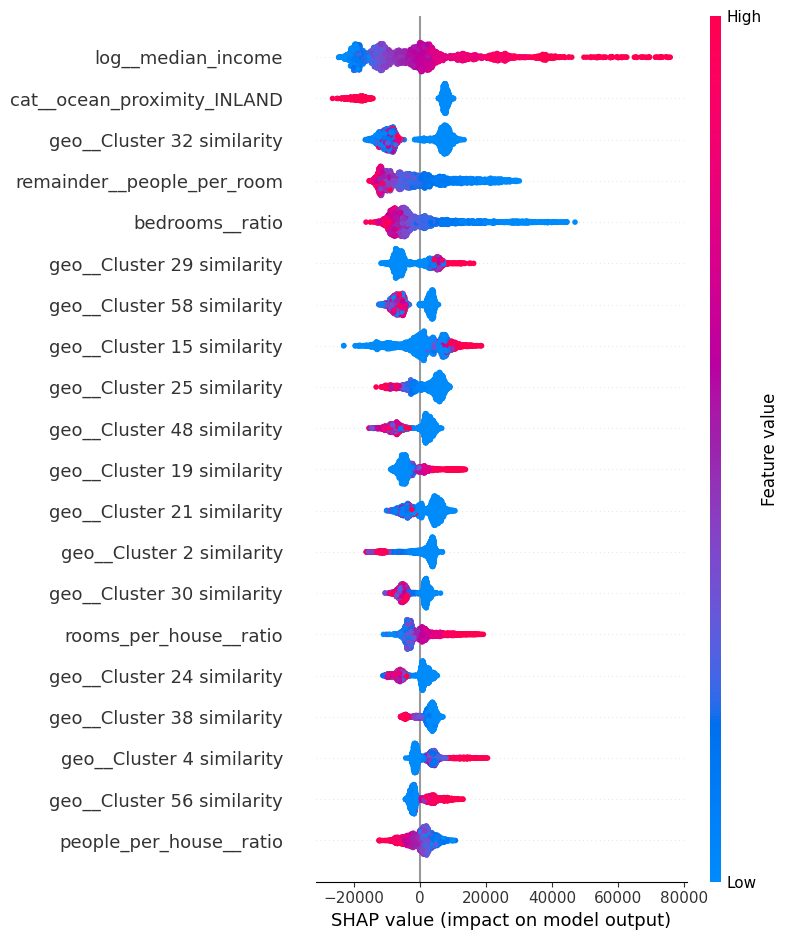

In [339]:
shap.summary_plot(shap_values, shap_data)


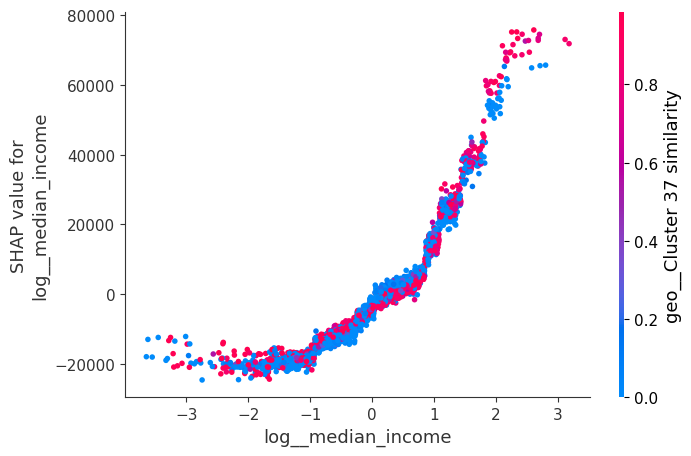

In [340]:
# Create a dependence plot for a specific feature, e.g., 'latitude'
shap.dependence_plot('log__median_income', shap_values, shap_data)


In [341]:
housing_predictions

array([435493.84 ,  90657.625, 163585.8  , ..., 246497.36 , 126172.31 ,
        75298.49 ], dtype=float32)

In [342]:
test_labels

13383    500001.0
3780      87100.0
17909    182000.0
12975     94800.0
15661    224200.0
           ...   
3240     143500.0
4325     182100.0
11567    265300.0
1855     141700.0
12333     78300.0
Name: median_housing_price, Length: 2808, dtype: float64

In [343]:
test_labels = test_labels[test_housing.index]

In [344]:
test_labels

13383    500001.0
3780      87100.0
17909    182000.0
12975     94800.0
15661    224200.0
           ...   
3240     143500.0
4325     182100.0
11567    265300.0
1855     141700.0
12333     78300.0
Name: median_housing_price, Length: 2808, dtype: float64

In [345]:
test_housing = test_housing.reset_index()

In [346]:
def urban_cluster_name(function_transformer, feature_names_in):
    return [f"urban_cluster {i}" for i in range(len(function_transformer.kw_args["Y"]))]

urban_cluster_transformer = FunctionTransformer(rbf_kernel, feature_names_out=urban_cluster_name, kw_args=dict(Y=urban_centers, gamma=0.1))
urban_cluster = urban_cluster_transformer.transform(test_housing[["latitude", "longitude"]])
urban_cluster = pd.DataFrame(urban_cluster, columns=urban_cluster_transformer.get_feature_names_out(), index=test_housing.index)
test_housing = test_housing.join(urban_cluster, how='inner')

In [347]:
test_housing

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,people_per_room,urban_cluster 0,urban_cluster 1,urban_cluster 2,urban_cluster 3
0,13383,-118.40,34.03,36.0,1831.0,296.0,871.0,269.0,8.1484,<1H OCEAN,0.475696,0.997511,0.048900,0.099276,0.721642
1,3780,-117.31,34.17,25.0,2795.0,596.0,1650.0,569.0,3.0078,INLAND,0.590340,0.915242,0.020038,0.045139,0.807578
2,17909,-119.12,34.23,35.0,2028.0,554.0,2252.0,521.0,2.4643,NEAR OCEAN,1.110454,0.923161,0.095825,0.177048,0.541702
3,12975,-122.22,38.08,37.0,4590.0,857.0,2920.0,832.0,3.4360,NEAR BAY,0.636166,0.040623,0.986803,0.935979,0.004353
4,15661,-122.01,37.55,26.0,2068.0,532.0,1434.0,495.0,3.3008,NEAR BAY,0.693424,0.071221,0.978417,0.994002,0.009203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2803,3240,-119.17,34.21,33.0,1039.0,256.0,1432.0,272.0,3.1103,NEAR OCEAN,1.378248,0.915492,0.097616,0.179713,0.534266
2804,4325,-117.93,33.87,52.0,950.0,229.0,429.0,185.0,2.3150,<1H OCEAN,0.451579,0.986926,0.029005,0.062783,0.825009
2805,11567,-122.01,36.98,47.0,1250.0,249.0,607.0,234.0,4.0417,NEAR OCEAN,0.485600,0.102725,0.923165,0.985742,0.015458
2806,1855,-117.08,32.64,11.0,1651.0,533.0,947.0,515.0,1.6806,NEAR OCEAN,0.573592,0.715445,0.004138,0.010918,0.998770


In [348]:
southern_urban_samples = test_housing[(test_housing["urban_cluster 0"] > 0.75) | (test_housing["urban_cluster 1"] > 0.75) | 
                                  (test_housing["urban_cluster 2"] > 0.75) | (test_housing["urban_cluster 3"] > 0.75)]
southern_urban_samples = southern_urban_samples[(southern_urban_samples["ocean_proximity"]=="<1H OCEAN") |
                                                 (southern_urban_samples["ocean_proximity"]=="NEAR OCEAN")| 
                                                 (southern_urban_samples["ocean_proximity"]=="NEAR BAY")]
southern_urban_samples

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,people_per_room,urban_cluster 0,urban_cluster 1,urban_cluster 2,urban_cluster 3
0,13383,-118.40,34.03,36.0,1831.0,296.0,871.0,269.0,8.1484,<1H OCEAN,0.475696,0.997511,0.048900,0.099276,0.721642
2,17909,-119.12,34.23,35.0,2028.0,554.0,2252.0,521.0,2.4643,NEAR OCEAN,1.110454,0.923161,0.095825,0.177048,0.541702
3,12975,-122.22,38.08,37.0,4590.0,857.0,2920.0,832.0,3.4360,NEAR BAY,0.636166,0.040623,0.986803,0.935979,0.004353
4,15661,-122.01,37.55,26.0,2068.0,532.0,1434.0,495.0,3.3008,NEAR BAY,0.693424,0.071221,0.978417,0.994002,0.009203
5,8052,-117.94,33.64,24.0,1097.0,307.0,470.0,333.0,1.6389,<1H OCEAN,0.428441,0.974126,0.024325,0.053665,0.864070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2802,20508,-118.31,33.83,50.0,696.0,311.0,382.0,234.0,2.7750,<1H OCEAN,0.548851,0.994638,0.038971,0.081289,0.774015
2803,3240,-119.17,34.21,33.0,1039.0,256.0,1432.0,272.0,3.1103,NEAR OCEAN,1.378248,0.915492,0.097616,0.179713,0.534266
2804,4325,-117.93,33.87,52.0,950.0,229.0,429.0,185.0,2.3150,<1H OCEAN,0.451579,0.986926,0.029005,0.062783,0.825009
2805,11567,-122.01,36.98,47.0,1250.0,249.0,607.0,234.0,4.0417,NEAR OCEAN,0.485600,0.102725,0.923165,0.985742,0.015458


In [349]:
housing_predictions = housing_predictions[southern_urban_samples.index]

In [350]:
len(housing_predictions)

1922

In [351]:
test_labels = test_labels.iloc[southern_urban_samples.index]

In [352]:
rmse = root_mean_squared_error(test_labels, housing_predictions)
rmse

42797.86091381971

In [353]:
result1 = test_labels.reset_index()
result1.drop("index", axis=1, inplace=True)
result1

,median_housing_price
0,500001.0
1,182000.0
2,94800.0
3,224200.0
4,225000.0
...,...
1917,225000.0
1918,143500.0
1919,182100.0
1920,265300.0


In [354]:
result1["housing_predictions"] = housing_predictions

In [355]:
result1

,median_housing_price,housing_predictions
0,500001.0,435493.843750
1,182000.0,163585.796875
2,94800.0,116363.367188
3,224200.0,193802.453125
4,225000.0,183162.546875
...,...,...
1917,225000.0,230476.578125
1918,143500.0,165958.312500
1919,182100.0,207320.109375
1920,265300.0,246497.359375


In [356]:
test_housing = test_housing.reset_index()

In [357]:
test_housing["error"] = (result1["median_housing_price"]-result1["housing_predictions"])

In [358]:
test_housing

,level_0,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,people_per_room,urban_cluster 0,urban_cluster 1,urban_cluster 2,urban_cluster 3,error
0,0,13383,-118.40,34.03,36.0,1831.0,296.0,871.0,269.0,8.1484,<1H OCEAN,0.475696,0.997511,0.048900,0.099276,0.721642,64507.156250
1,1,3780,-117.31,34.17,25.0,2795.0,596.0,1650.0,569.0,3.0078,INLAND,0.590340,0.915242,0.020038,0.045139,0.807578,18414.203125
2,2,17909,-119.12,34.23,35.0,2028.0,554.0,2252.0,521.0,2.4643,NEAR OCEAN,1.110454,0.923161,0.095825,0.177048,0.541702,-21563.367188
3,3,12975,-122.22,38.08,37.0,4590.0,857.0,2920.0,832.0,3.4360,NEAR BAY,0.636166,0.040623,0.986803,0.935979,0.004353,30397.546875
4,4,15661,-122.01,37.55,26.0,2068.0,532.0,1434.0,495.0,3.3008,NEAR BAY,0.693424,0.071221,0.978417,0.994002,0.009203,41837.453125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2803,2803,3240,-119.17,34.21,33.0,1039.0,256.0,1432.0,272.0,3.1103,NEAR OCEAN,1.378248,0.915492,0.097616,0.179713,0.534266,NaN
2804,2804,4325,-117.93,33.87,52.0,950.0,229.0,429.0,185.0,2.3150,<1H OCEAN,0.451579,0.986926,0.029005,0.062783,0.825009,NaN
2805,2805,11567,-122.01,36.98,47.0,1250.0,249.0,607.0,234.0,4.0417,NEAR OCEAN,0.485600,0.102725,0.923165,0.985742,0.015458,NaN
2806,2806,1855,-117.08,32.64,11.0,1651.0,533.0,947.0,515.0,1.6806,NEAR OCEAN,0.573592,0.715445,0.004138,0.010918,0.998770,NaN


In [359]:
res1 = result1[(result1["median_housing_price"] - result1["housing_predictions"]) > 50000]
len(res1)

169

In [360]:
res2 = result1[(result1["housing_predictions"]-result1["median_housing_price"]) > 50000]
len(res2)

122

In [361]:
inter = test_housing.iloc[res1.index]
inter

,level_0,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,people_per_room,urban_cluster 0,urban_cluster 1,urban_cluster 2,urban_cluster 3,error
0,0,13383,-118.40,34.03,36.0,1831.0,296.0,871.0,269.0,8.1484,<1H OCEAN,0.475696,0.997511,0.048900,0.099276,0.721642,64507.156250
17,17,12995,-122.42,37.93,47.0,3453.0,779.0,1353.0,728.0,4.0160,NEAR BAY,0.391833,0.038856,0.997597,0.938468,0.004151,51334.375000
34,34,10829,-117.64,34.12,18.0,3605.0,534.0,1682.0,480.0,5.8407,INLAND,0.466574,0.963768,0.026780,0.058497,0.802406,80953.281250
50,50,1436,-117.26,33.04,16.0,3109.0,450.0,1433.0,453.0,6.6319,NEAR OCEAN,0.460920,0.819368,0.007418,0.018542,0.988571,56551.125000
88,88,16883,-117.91,33.84,29.0,1570.0,482.0,1849.0,430.0,2.6563,<1H OCEAN,1.177707,0.984483,0.027825,0.060517,0.833193,67032.187500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1852,1852,3609,-116.84,32.86,16.0,2502.0,532.0,1211.0,494.0,3.2516,<1H OCEAN,0.484013,0.712360,0.003972,0.010547,0.987684,181461.656250
1859,1859,5049,-117.91,33.78,33.0,2729.0,549.0,2223.0,535.0,4.0362,<1H OCEAN,0.814584,0.981626,0.026532,0.058008,0.844206,106001.125000
1870,1870,2763,-122.48,38.51,49.0,1977.0,393.0,741.0,339.0,3.1312,INLAND,0.374810,0.022781,0.947049,0.841508,0.002057,97207.875000
1886,1886,10643,-121.80,38.01,37.0,3058.0,567.0,1351.0,523.0,3.5179,INLAND,0.441792,0.058945,0.957057,0.955160,0.007049,63356.625000


In [362]:
inter2 = test_housing.iloc[res2.index]
inter2

,level_0,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,people_per_room,urban_cluster 0,urban_cluster 1,urban_cluster 2,urban_cluster 3,error
16,16,1875,-118.38,34.17,33.0,1588.0,454.0,739.0,392.0,2.8208,<1H OCEAN,0.465365,0.996760,0.053333,0.107189,0.697627,-56552.703125
25,25,7227,-117.93,33.93,25.0,2431.0,534.0,1702.0,523.0,3.7933,<1H OCEAN,0.700123,0.988730,0.030385,0.065427,0.813367,-72046.281250
29,29,6033,-117.93,33.76,24.0,3202.0,703.0,3308.0,714.0,4.1577,<1H OCEAN,1.033104,0.981789,0.026585,0.058100,0.845204,-56231.078125
30,30,8611,-118.24,34.16,52.0,1904.0,297.0,797.0,286.0,6.6603,<1H OCEAN,0.418592,0.998837,0.047194,0.096362,0.722525,-75330.203125
36,36,16519,-117.86,34.01,16.0,4632.0,NaN,3038.0,727.0,5.1762,<1H OCEAN,0.655872,0.985210,0.030311,0.065298,0.805439,-55393.906250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1865,1865,6348,-120.86,37.49,22.0,2140.0,445.0,1441.0,409.0,2.4706,INLAND,0.673364,0.154687,0.777797,0.897957,0.026054,-69340.156250
1906,1906,7663,-121.51,38.52,30.0,3236.0,588.0,1167.0,569.0,4.0972,INLAND,0.360630,0.046747,0.870909,0.857422,0.005194,-71150.562500
1909,1909,1787,-122.43,40.47,16.0,3552.0,704.0,1801.0,658.0,2.1496,INLAND,0.507038,0.002819,0.483663,0.364081,0.000152,-73785.750000
1911,1911,3500,-122.02,37.09,35.0,1818.0,368.0,682.0,254.0,4.8611,NEAR OCEAN,0.375138,0.095477,0.939074,0.992084,0.013921,-57466.453125


In [363]:
inter["median_housing_value"] = res1["median_housing_price"]
inter

C:\Users\huzai\AppData\Local\Temp\ipykernel_13804\3948947913.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inter["median_housing_value"] = res1["median_housing_price"]


,level_0,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,people_per_room,urban_cluster 0,urban_cluster 1,urban_cluster 2,urban_cluster 3,error,median_housing_value
0,0,13383,-118.40,34.03,36.0,1831.0,296.0,871.0,269.0,8.1484,<1H OCEAN,0.475696,0.997511,0.048900,0.099276,0.721642,64507.156250,500001.0
17,17,12995,-122.42,37.93,47.0,3453.0,779.0,1353.0,728.0,4.0160,NEAR BAY,0.391833,0.038856,0.997597,0.938468,0.004151,51334.375000,488500.0
34,34,10829,-117.64,34.12,18.0,3605.0,534.0,1682.0,480.0,5.8407,INLAND,0.466574,0.963768,0.026780,0.058497,0.802406,80953.281250,351800.0
50,50,1436,-117.26,33.04,16.0,3109.0,450.0,1433.0,453.0,6.6319,NEAR OCEAN,0.460920,0.819368,0.007418,0.018542,0.988571,56551.125000,456900.0
88,88,16883,-117.91,33.84,29.0,1570.0,482.0,1849.0,430.0,2.6563,<1H OCEAN,1.177707,0.984483,0.027825,0.060517,0.833193,67032.187500,225600.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1852,1852,3609,-116.84,32.86,16.0,2502.0,532.0,1211.0,494.0,3.2516,<1H OCEAN,0.484013,0.712360,0.003972,0.010547,0.987684,181461.656250,464300.0
1859,1859,5049,-117.91,33.78,33.0,2729.0,549.0,2223.0,535.0,4.0362,<1H OCEAN,0.814584,0.981626,0.026532,0.058008,0.844206,106001.125000,437400.0
1870,1870,2763,-122.48,38.51,49.0,1977.0,393.0,741.0,339.0,3.1312,INLAND,0.374810,0.022781,0.947049,0.841508,0.002057,97207.875000,362500.0
1886,1886,10643,-121.80,38.01,37.0,3058.0,567.0,1351.0,523.0,3.5179,INLAND,0.441792,0.058945,0.957057,0.955160,0.007049,63356.625000,394400.0


In [364]:
inter2["median_housing_value"] = res2["median_housing_price"]
inter2

C:\Users\huzai\AppData\Local\Temp\ipykernel_13804\4176855113.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inter2["median_housing_value"] = res2["median_housing_price"]


,level_0,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,people_per_room,urban_cluster 0,urban_cluster 1,urban_cluster 2,urban_cluster 3,error,median_housing_value
16,16,1875,-118.38,34.17,33.0,1588.0,454.0,739.0,392.0,2.8208,<1H OCEAN,0.465365,0.996760,0.053333,0.107189,0.697627,-56552.703125,167400.0
25,25,7227,-117.93,33.93,25.0,2431.0,534.0,1702.0,523.0,3.7933,<1H OCEAN,0.700123,0.988730,0.030385,0.065427,0.813367,-72046.281250,151000.0
29,29,6033,-117.93,33.76,24.0,3202.0,703.0,3308.0,714.0,4.1577,<1H OCEAN,1.033104,0.981789,0.026585,0.058100,0.845204,-56231.078125,133300.0
30,30,8611,-118.24,34.16,52.0,1904.0,297.0,797.0,286.0,6.6603,<1H OCEAN,0.418592,0.998837,0.047194,0.096362,0.722525,-75330.203125,143000.0
36,36,16519,-117.86,34.01,16.0,4632.0,NaN,3038.0,727.0,5.1762,<1H OCEAN,0.655872,0.985210,0.030311,0.065298,0.805439,-55393.906250,269600.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1865,1865,6348,-120.86,37.49,22.0,2140.0,445.0,1441.0,409.0,2.4706,INLAND,0.673364,0.154687,0.777797,0.897957,0.026054,-69340.156250,102200.0
1906,1906,7663,-121.51,38.52,30.0,3236.0,588.0,1167.0,569.0,4.0972,INLAND,0.360630,0.046747,0.870909,0.857422,0.005194,-71150.562500,333300.0
1909,1909,1787,-122.43,40.47,16.0,3552.0,704.0,1801.0,658.0,2.1496,INLAND,0.507038,0.002819,0.483663,0.364081,0.000152,-73785.750000,233900.0
1911,1911,3500,-122.02,37.09,35.0,1818.0,368.0,682.0,254.0,4.8611,NEAR OCEAN,0.375138,0.095477,0.939074,0.992084,0.013921,-57466.453125,199800.0


In [365]:
inter2.describe()

,level_0,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,people_per_room,urban_cluster 0,urban_cluster 1,urban_cluster 2,urban_cluster 3,error,median_housing_value
count,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,120.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000
mean,1001.418033,9790.680328,-119.561148,35.538689,30.352459,2300.614754,469.150000,1318.163934,442.311475,3.636655,0.619107,0.601130,0.373021,0.400783,0.458975,-78921.096696,216234.426230
std,560.431974,6361.878925,1.966898,2.048898,11.970295,1140.390874,210.885315,680.916924,202.363190,1.543169,0.268766,0.436537,0.422856,0.403417,0.380486,35787.123351,86552.851833
min,16.000000,4.000000,-123.160000,32.600000,4.000000,369.000000,107.000000,326.000000,108.000000,1.195700,0.174277,0.002819,0.000929,0.002637,0.000152,-267140.468750,55000.000000
25%,562.750000,4545.250000,-121.685000,33.962500,22.000000,1503.000000,313.500000,834.000000,304.000000,2.465050,0.450172,0.070491,0.035398,0.074819,0.009653,-83216.421875,154275.000000
50%,1061.000000,8934.000000,-118.430000,34.175000,31.000000,1960.500000,438.000000,1162.500000,395.500000,3.288800,0.524825,0.886204,0.053764,0.107850,0.685156,-66576.882812,200000.000000
75%,1465.000000,15446.500000,-118.062500,37.715000,39.000000,2915.250000,604.500000,1660.500000,559.250000,4.594325,0.707103,0.992691,0.876868,0.897956,0.785519,-57473.550781,267125.000000
max,1916.000000,20528.000000,-114.600000,41.400000,52.000000,5392.000000,1168.000000,3868.000000,1117.000000,8.562100,2.231776,0.999930,0.999928,0.999339,0.999606,-50200.750000,420300.000000


In [366]:
inter.drop(columns=["index"], axis=1, inplace=True)
inter2.drop(columns=["index"], axis=1, inplace=True)

C:\Users\huzai\AppData\Local\Temp\ipykernel_13804\3546893112.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inter.drop(columns=["index"], axis=1, inplace=True)
C:\Users\huzai\AppData\Local\Temp\ipykernel_13804\3546893112.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inter2.drop(columns=["index"], axis=1, inplace=True)


In [367]:
inter[inter["urban_cluster 0"]>0.99].describe()

,level_0,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,people_per_room,urban_cluster 0,urban_cluster 1,urban_cluster 2,urban_cluster 3,error,median_housing_value
count,46.000000,46.000000,46.000000,46.000000,46.000000,44.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000
mean,913.695652,-118.243696,34.032609,34.760870,2250.108696,504.568182,1472.673913,493.065217,3.592615,0.708533,0.996653,0.043537,0.089578,0.746214,98557.119905,392708.934783
std,521.914121,0.135127,0.125085,9.463814,1126.084904,242.845668,744.019744,272.235225,1.707981,0.299903,0.002500,0.007222,0.013014,0.036819,43515.791996,96364.123907
min,0.000000,-118.500000,33.760000,13.000000,438.000000,167.000000,322.000000,161.000000,0.847800,0.352298,0.990433,0.031960,0.068301,0.668607,51028.078125,175900.000000
25%,496.500000,-118.347500,33.942500,29.250000,1501.250000,328.750000,921.000000,323.250000,2.252225,0.476300,0.995134,0.039071,0.081581,0.718392,70085.929688,324150.000000
50%,875.000000,-118.240000,34.025000,35.000000,2199.500000,473.500000,1307.000000,457.000000,3.416850,0.607146,0.997285,0.042084,0.087052,0.753784,86352.328125,396900.000000
75%,1354.500000,-118.132500,34.157500,42.000000,2589.250000,607.000000,1981.250000,592.750000,4.576775,0.915372,0.998510,0.048994,0.099382,0.769915,112315.824219,498450.000000
max,1819.000000,-117.940000,34.260000,52.000000,6347.000000,1299.000000,3817.000000,1492.000000,8.148400,1.575342,0.999886,0.060385,0.119401,0.814744,224411.218750,500001.000000


In [368]:
inter2[inter2["urban_cluster 0"]>0.99].describe()

,level_0,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,people_per_room,urban_cluster 0,urban_cluster 1,urban_cluster 2,urban_cluster 3,error,median_housing_value
count,42.000000,42.000000,42.000000,42.000000,42.000000,41.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000
mean,897.452381,-118.251905,34.008333,34.452381,1967.476190,452.634146,1258.595238,423.023810,3.560557,0.719923,0.995783,0.043122,0.088783,0.749204,-75602.683408,221185.714286
std,566.764295,0.158195,0.127546,9.109637,1063.073185,232.741891,673.297059,220.719167,1.654169,0.363895,0.003035,0.007773,0.014022,0.039446,35265.441681,82733.417236
min,16.000000,-118.530000,33.750000,12.000000,483.000000,113.000000,389.000000,108.000000,1.201200,0.339370,0.990697,0.031080,0.066728,0.664805,-267140.468750,93800.000000
25%,415.750000,-118.390000,33.892500,30.000000,1366.000000,306.000000,817.500000,287.250000,2.410475,0.481379,0.992659,0.037503,0.078761,0.721934,-82789.949219,162500.000000
50%,819.000000,-118.265000,34.020000,35.000000,1755.500000,424.000000,1097.000000,364.500000,3.241550,0.573205,0.996191,0.042480,0.087720,0.750557,-68478.171875,212450.000000
75%,1408.750000,-118.145000,34.085000,41.500000,2421.500000,489.000000,1610.250000,479.250000,4.454425,0.945097,0.998621,0.048697,0.098922,0.772600,-56584.394531,267725.000000
max,1916.000000,-117.960000,34.280000,52.000000,4822.000000,1168.000000,3868.000000,1117.000000,8.562100,2.231776,0.999930,0.060507,0.119677,0.813474,-50200.750000,406900.000000


In [369]:
x = xgb_reg1.named_steps["preprocessing1"]
inter2_shap = x.fit_transform(inter2)
inter2_shap  = pd.DataFrame(inter2_shap, columns=x.get_feature_names_out(), index=inter2.index)
inter2_shap.columns = inter2_shap.columns.str.replace('<', 'LT', regex=False)  # Replace '<' with 'LT'

In [370]:
inter2_shap

,bedrooms__ratio,rooms_per_house__ratio,people_per_house__ratio,log__total_bedrooms,log__total_rooms,log__population,log__households,log__median_income,geo__Cluster 0 similarity,geo__Cluster 1 similarity,...,cat__ocean_proximity_NEAR OCEAN,remainder__level_0,remainder__housing_median_age,remainder__people_per_room,remainder__urban_cluster 0,remainder__urban_cluster 1,remainder__urban_cluster 2,remainder__urban_cluster 3,remainder__error,remainder__median_housing_value
16,1.191229,-0.964414,-1.452001,0.154110,-0.438768,-0.875490,-0.023422,-0.376574,1.053730e-11,9.080099e-01,...,0.0,-1.765570,0.222088,-0.574387,0.910028,-0.759139,-0.730771,0.629815,0.627618,-0.566542
25,0.062504,-0.473794,0.287899,0.493161,0.346976,0.744623,0.570680,0.306810,6.026650e-14,9.342605e-01,...,0.0,-1.749444,-0.448989,0.302683,0.891558,-0.813631,-0.834717,0.935259,0.192895,-0.756803
29,0.060588,-0.608197,2.040066,1.067569,0.855284,2.035142,1.212139,0.518426,1.608483e-14,8.422318e-01,...,0.0,-1.742278,-0.532874,1.546719,0.875592,-0.822655,-0.852954,1.019279,0.636642,-0.962145
30,-1.022657,1.176900,-0.306330,-0.732411,-0.103895,-0.728760,-0.673059,1.605514,3.560928e-12,9.714165e-01,...,0.0,-1.740486,1.815896,-0.749133,0.914806,-0.773716,-0.757720,0.695523,0.100754,-0.849613
36,-2.069517,0.941966,1.462806,0.079159,1.536562,1.869794,1.249319,1.023922,6.251937e-14,9.382864e-01,...,0.0,-1.729736,-1.203951,0.137358,0.883461,-0.813808,-0.835040,0.914338,0.660132,0.619109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1865,-0.137208,0.006086,0.629659,0.112281,0.111717,0.421350,0.064056,-0.682396,3.004422e-01,5.951039e-09,...,0.0,1.547276,-0.700643,0.202710,-1.026908,0.961191,1.237488,-1.142503,0.268824,-1.322945
1906,-0.584361,0.379822,-1.241344,0.694402,0.874774,0.011786,0.744384,0.484609,4.491044e-01,3.690239e-14,...,0.0,1.620736,-0.029566,-0.965683,-1.275192,1.182295,1.136595,-1.197554,0.218028,1.358110
1909,-0.303296,0.142389,-0.369403,1.070538,1.046698,0.854419,1.043836,-1.003489,4.274813e-04,2.497306e-26,...,0.0,1.626111,-1.203951,-0.418695,-1.376236,0.262732,-0.091353,-1.210859,0.144089,0.204943
1911,-0.231344,1.587806,-0.435541,-0.284620,-0.189181,-1.031368,-0.917561,0.879025,6.585598e-01,2.951566e-11,...,1.0,1.629694,0.389857,-0.911484,-1.163103,1.344163,1.471775,-1.174522,0.601980,-0.190660


In [371]:
inter2_shap.drop(["remainder__urban_cluster 0", "remainder__urban_cluster 1",	"remainder__urban_cluster 2", "remainder__urban_cluster 3", "remainder__median_housing_value", "remainder__error"], axis=1, inplace=True)

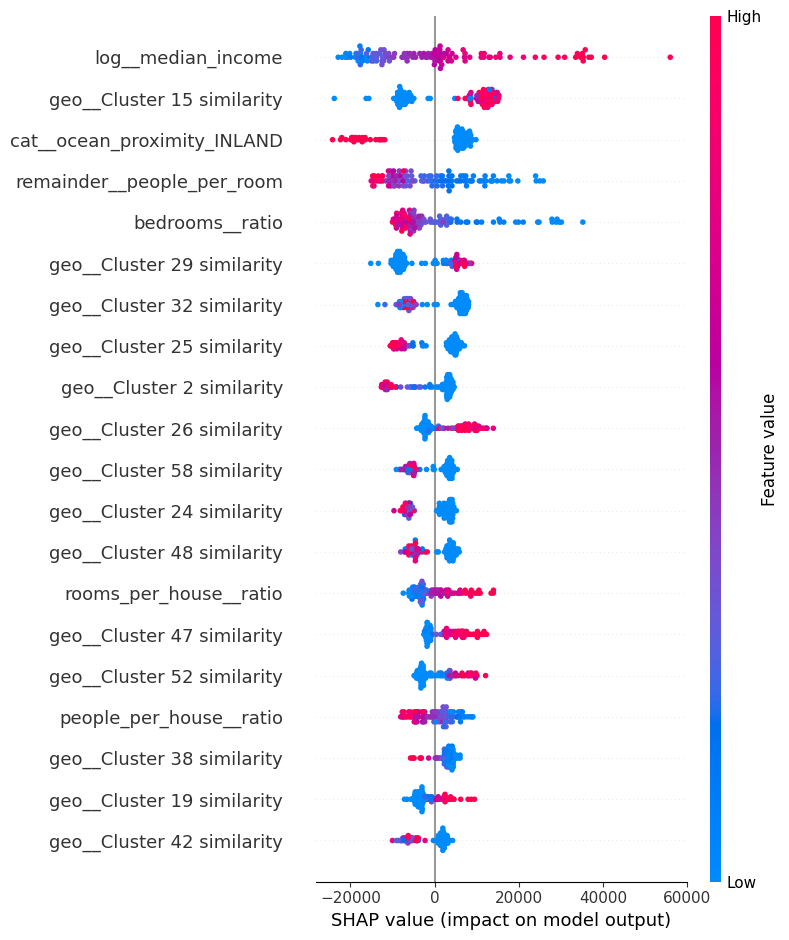

In [372]:
# Assuming you have latitude and longitude in your data and you want to filter southern California

# Compute SHAP values for this subset
shap_values = explainer.shap_values(inter2_shap)

# Visualize SHAP summary plot for southern California
shap.summary_plot(shap_values, inter2_shap)

In [373]:
xgb_rmses = -cross_val_score(xgb_reg1, housing3, housing_labels,
                                scoring="neg_root_mean_squared_error", cv=3)
pd.Series(xgb_rmses).describe()

count        3.000000
mean     38102.429288
std       1097.071699
min      36911.439074
25%      37617.784006
50%      38324.128938
75%      38697.924395
max      39071.719852
dtype: float64

In [374]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=100)
test_housing['cluster'] = kmeans.fit_predict(test_housing[['longitude', 'latitude']])

# Analyze the errors by cluster
cluster_errors = test_housing.groupby('cluster')['error'].mean()
cluster_errors


cluster
0     22928.875000
1      2628.101693
2      3243.042126
3      9846.364258
4     -7614.092708
          ...     
95    -9294.304688
96    -2295.736213
97             NaN
98    -2921.043478
99    73892.010417
Name: error, Length: 100, dtype: float64

In [375]:
cluster_errors.describe()


count       97.000000
mean      1364.574194
std      17171.384779
min     -58516.679688
25%      -6708.468750
50%       2285.838825
75%       8857.235547
max      73892.010417
Name: error, dtype: float64

In [376]:
centers_under = kmeans.cluster_centers_[cluster_errors>30000]
centers_over = kmeans.cluster_centers_[cluster_errors<-5000]
centers_under = pd.DataFrame(centers_under, columns=["longitude", "latitude"])
centers_over = pd.DataFrame(centers_over, columns=["longitude", "latitude"])

In [377]:
centers_under

,longitude,latitude
0,-120.700000,35.476250
1,-120.642222,38.594444
2,-120.822500,37.072500


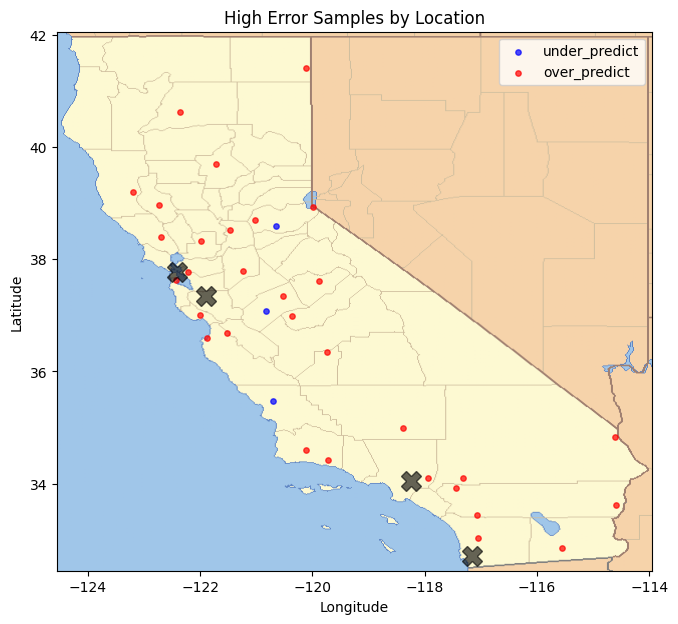

In [378]:
IMAGES_PATH = Path()
IMAGES_PATH.mkdir(parents=True, exist_ok=True)
filename = "california.png"
if not (IMAGES_PATH / filename).is_file():
    homl3_root = "https://github.com/ageron/handson-ml3/raw/main/"
    url = homl3_root + "images/end_to_end_project/" + filename
    print("Downloading", filename)
    urllib.request.urlretrieve(url, IMAGES_PATH / filename)

plt.figure(figsize=(10, 7))
plt.scatter(centers_under['longitude'], centers_under['latitude'], c='blue', s=15, label='under_predict', alpha=0.7)
plt.scatter(centers_over['longitude'], centers_over['latitude'], c='red', s=15, label='over_predict', alpha=0.7)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('High Error Samples by Location')
plt.legend()

plt.plot(urban_centers[:, 1],
         urban_centers[:, 0],
         linestyle="", color="black", marker="X", markersize=15,
         label="Cluster centers", alpha=0.6)

california_img = plt.imread(IMAGES_PATH / filename)
axis = -124.55, -113.95, 32.45, 42.05
plt.axis(axis)
plt.imshow(california_img, extent=axis)
plt.show()

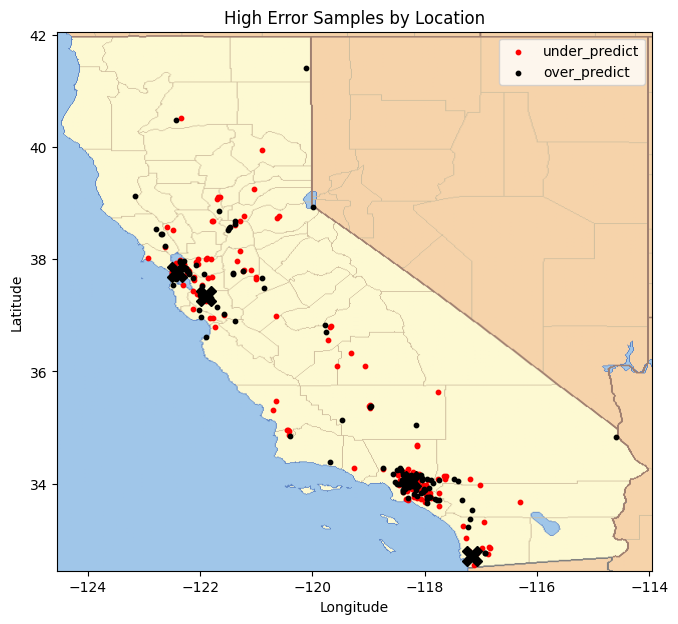

In [379]:
IMAGES_PATH = Path()
IMAGES_PATH.mkdir(parents=True, exist_ok=True)
filename = "california.png"
if not (IMAGES_PATH / filename).is_file():
    homl3_root = "https://github.com/ageron/handson-ml3/raw/main/"
    url = homl3_root + "images/end_to_end_project/" + filename
    print("Downloading", filename)
    urllib.request.urlretrieve(url, IMAGES_PATH / filename)

plt.figure(figsize=(10, 7))
plt.scatter(inter['longitude'], inter['latitude'], c='red', s=10, label='under_predict', alpha=1)
plt.scatter(inter2['longitude'], inter2['latitude'], c='black', s=10, label='over_predict', alpha=1)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('High Error Samples by Location')
plt.legend()

plt.plot(urban_centers[:, 1],
         urban_centers[:, 0],
         linestyle="", color="black", marker="X", markersize=15,
         label="Cluster centers", alpha=1)

california_img = plt.imread(IMAGES_PATH / filename)
axis = -124.55, -113.95, 32.45, 42.05
plt.axis(axis)
plt.imshow(california_img, extent=axis)
plt.show()


Here's, Thes summary of what all i did, some of their code is missing so yeah----Not everything worked to be exact most of them didn't worked
but was great learning experience:

1- Feature Engineering: Created new features, like room_per_person, using existing features (e.g., total rooms and population). These worked well.

2- Outlier Removal: Removed 2,064 outliers using Isolation Forest and manually removed 300 more based on low district population or unrealistic       ratios. Used a color-mapped histogram to visualize outliers and assess the median housing price's relation to each feature.

3- Pipeline Development: Built custom transformers, including one for cluster similarity (which was effective) and created a processing pipeline to    handle scaling, imputation, log transformation (for skewed features), and other transformations.

4- Model Selection: Initial models like linear regression and SVR (linear and polynomial) performed poorly. Decision tree regressor overfitted and did not generalize well on validation data. Random forest and XGBoost regressors, however, performed well.

5- Hyperparameter Tuning: Used RandomizedSearchCV and Optuna for hyperparameter tuning, with Optuna yielding the best parameters.

6- Error Visualization and Analysis: Investigated error concentrations using scatter plots and KMeans clustering, identifying the southern coastline as an area of high error.

6- Error Diagnosis: Found significant underprediction errors in urban centers along the southern coast, likely due to overfitting and underfitting.

7- Urban Center Proximity: Added latitude and longitude of important urban centers, calculated haversine distances to each, and adjusted model weighting to reduce errors for southern urban center samples.

8- SHAP Analysis: Examined SHAP values to understand which features contributed most to overprediction and underprediction. This analysis was informative but did not directly reduce errors.

9- Separate Model for High-Error Regions: Created a separate model for the southern coastline to address high error rates in this region.

10- Findings: Concluded that errors in southern urban centers were partly due to missing features like education facilities, healthcare, entertainment, population density, and crime indices. The dataset was also limited in size—after removing outliers and the test set, only around 14,000 samples were left for training, which likely affected the model's performance.